In [1]:
# Uncomment and run if you do not have these packages installed or are outdated
#!pip install kemlglearn --upgrade
#!pip install scikit-learn --upgrade

# Scalable Clustering

In [2]:
%matplotlib notebook
from sklearn.cluster import Birch, MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import time
from sklearn.metrics import adjusted_mutual_info_score
import warnings
from kemlglearn.datasets import make_blobs

warnings.filterwarnings("ignore")


citypath = '../Data/' # Adjust the path to your local dataset to run
data = 'LONpos.csv.gz'
citypos = loadtxt(citypath+data, delimiter=',')
nclusters = 201

Most of the clustering algorithms that we have seen do not scale to large number of examples or even clusters

We will play with geographical data of crimes commited in the city of london (over 85.000 examples)

## Increasing the number of clusters

Most of the clustering algorithms that we have seen do not scale to large number of examples or even clusters


Let's see what happens with K-means when we increase the number of clusters

### K-means

<IPython.core.display.Javascript object>


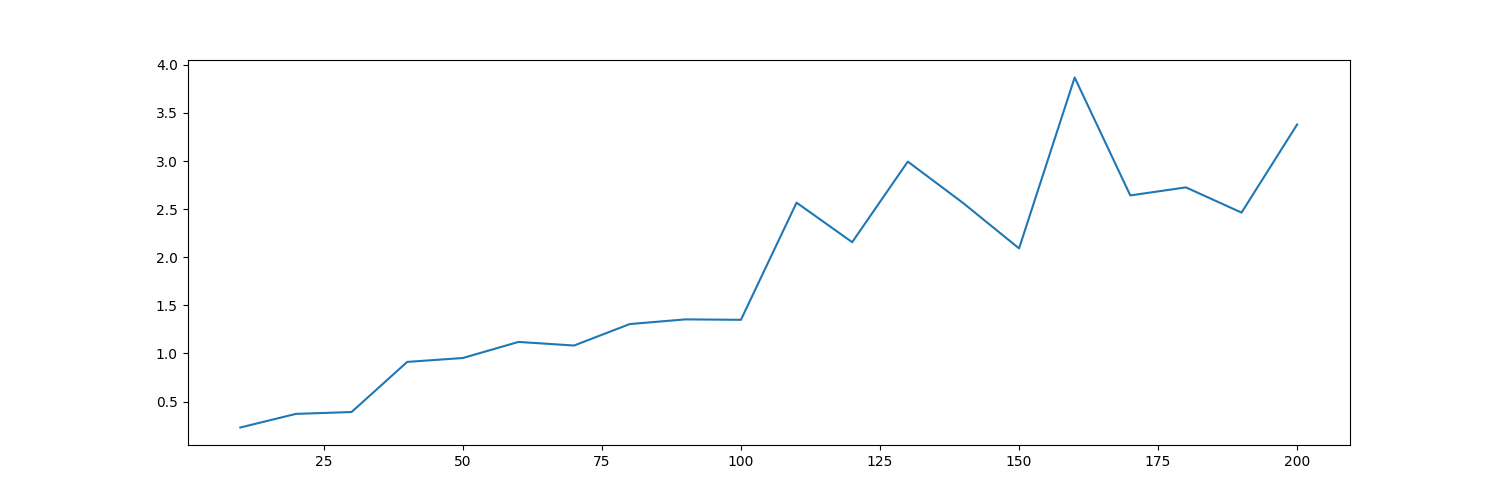

In [3]:
ltimes = []
for nc in range(10, nclusters, 10):
    km = KMeans(n_clusters=nc, n_init=1)
    itime = time.perf_counter()
    kmlabels = km.fit_predict(citypos)
    etime = time.perf_counter()
    ltimes.append(etime-itime)
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.plot(range(10, nclusters, 10), ltimes);

### Minibatch K-means

Minibatch K-means is an incremental version of K-means that uses random batches of examples to reduce the amount of memory and time. It is designed for datasets that can not be stored in memory, the size of the batch could improve the results if the clusters are difficult to find, if not small sizes can obtain results good enough in practice.

<IPython.core.display.Javascript object>


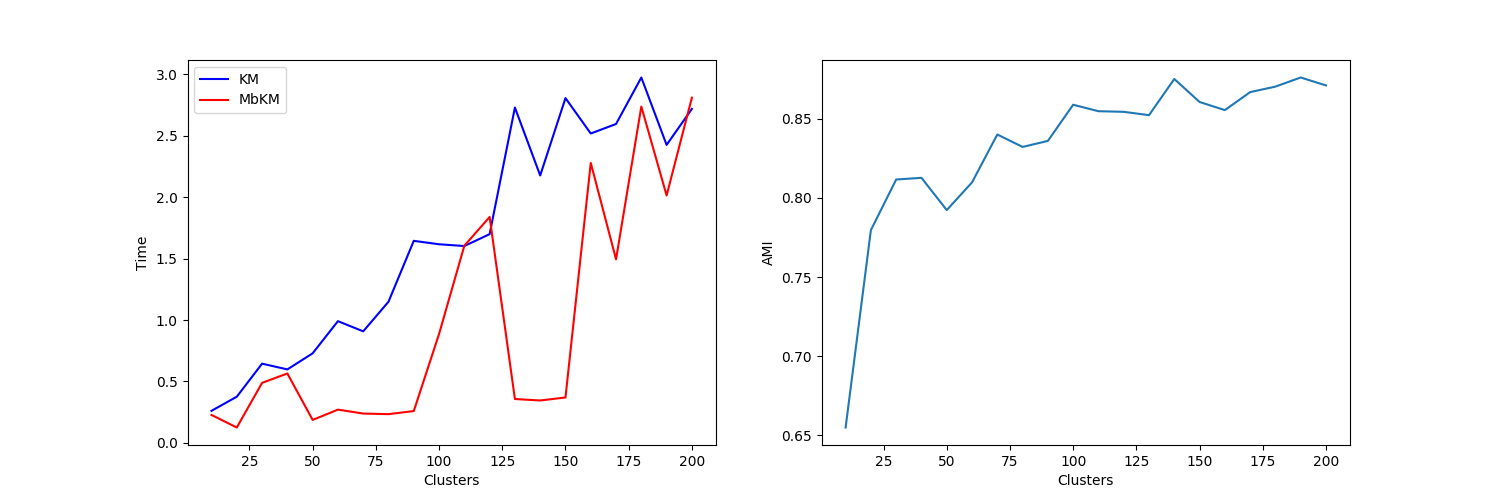

In [4]:
ltimes = []
ltimeskm = []
agree = []
mblb = []
kmlb = []

for nc in range(10, nclusters, 10):
    mbkm = MiniBatchKMeans(n_clusters=nc, batch_size=500, n_init=1, max_iter=5000)
    itime = time.perf_counter()
    mblb.append(mbkm.fit_predict(citypos))
    etime = time.perf_counter()
    ltimes.append(etime-itime)
    
for nc in range(10, nclusters, 10):    
    km = KMeans(n_clusters=nc, n_init=1)
    itime = time.perf_counter()
    kmlb.append(km.fit_predict(citypos))
    etime = time.perf_counter()
    ltimeskm.append(etime-itime)
    
for mbkmlabels, kmlabels in zip(mblb,kmlb):
    agree.append(adjusted_mutual_info_score(mbkmlabels, kmlabels))
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.plot(range(10, nclusters, 10), ltimeskm, color='b', label='KM')
plt.plot(range(10, nclusters, 10), ltimes, color='r', label='MbKM')
plt.xlabel('Clusters')
plt.ylabel('Time')
plt.legend()
ax = fig.add_subplot(122)
plt.plot(range(10, nclusters, 10), agree)
plt.xlabel('Clusters')
plt.ylabel('AMI');

### BIRCH

BIRCH is an algorithm that compresses the data to certain granularity using the Leader algorithm to reduce the data size and uses an indexing datastructure for fast assignment, the adjustment of its parameters is key for good results. Also assumes that the whole dataset does not fits in memory but the compressed data is a good approximation of the data densities.

<IPython.core.display.Javascript object>


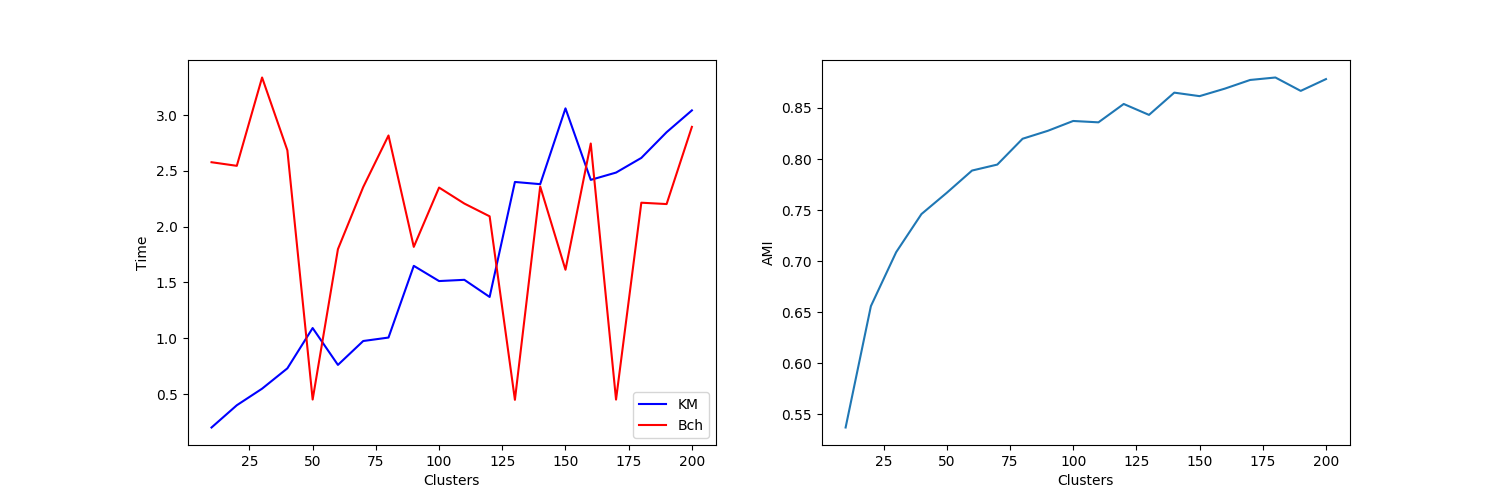

In [6]:
ltimes = []
ltimeskm = []
agree = []
brlb = []
kmlb = []

for nc in range(10, nclusters, 10):
    birch = Birch(threshold=0.02, n_clusters=nc, branching_factor=100)
    itime = time.perf_counter()
    brlb.append(mbkm.fit_predict(citypos))
    etime = time.perf_counter()
    ltimes.append(etime-itime)
    
for nc in range(10, nclusters, 10):    
    km = KMeans(n_clusters=nc, n_init=1)
    itime = time.perf_counter()
    kmlb.append(km.fit_predict(citypos))
    etime = time.perf_counter()
    ltimeskm.append(etime-itime)
    
for birchlabels, kmlabels in zip(brlb,kmlb):    
    agree.append(adjusted_mutual_info_score(birchlabels, kmlabels))
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.plot(range(10, nclusters, 10), ltimeskm, color='b', label='KM')
plt.plot(range(10, nclusters, 10), ltimes, color='r', label='Bch')
plt.xlabel('Clusters')
plt.ylabel('Time')
plt.legend()
ax = fig.add_subplot(122)
plt.plot(range(10, nclusters, 10), agree);
plt.xlabel('Clusters')
plt.ylabel('AMI');

The implementation of scikit-learn of BIRCH does not always do a good job because the final number of clusters is obtained using agglomerative hierarchical clustering

## Increasing the size of the dataset

Now let's see what happens if we increase the size of the dataset. For this we are going to generate randomly spherical blobs of with increasing numbers of examples.

The three algorithms are computed for the data and the time used and the agreement with the original labels is collected. The size of the batches of minibatch K-means and Birch branching factor are set to a 5% of the size of the dataset, this is just a random guess and these parameter have to be carefully set.

If you run this cell again it takes some time to complete. You have also this code in the /Code folder so yu can run it outside the notebooks and explore different options.

In [7]:
ltimes = []
agree = []
step = 10000
limit = 100001
ncenters = 50
for ns in range(step, limit, step):
    blobs, labels = make_blobs(n_samples=ns, n_features=20, centers=ncenters, cluster_std=1, center_box=(-3,3))
    # KMeans
    km = KMeans(n_clusters=ncenters, n_init=1)
    itime = time.perf_counter()
    kmlabels = km.fit_predict(blobs)
    etime = time.perf_counter()
    dtime1 = etime-itime
    agg1 = adjusted_mutual_info_score(labels, kmlabels)

    # Minibatch Kmeans
    itime = time.perf_counter()
    mbkm = MiniBatchKMeans(n_clusters=ncenters, batch_size=int(ns/20), n_init=1)
    mbkmlabels = mbkm.fit_predict(blobs)
    etime = time.perf_counter()
    dtime2 = etime-itime
    agg2 = adjusted_mutual_info_score(labels, mbkmlabels)

    # Birch
    itime = time.perf_counter()
    birch = Birch(threshold=5, n_clusters=ncenters, branching_factor=int(ns/20))
    birchlabels = birch.fit_predict(blobs)
    etime = time.perf_counter()
    dtime3 = etime-itime
    agg3 = adjusted_mutual_info_score(labels, birchlabels)

    ltimes.append((dtime1, dtime2, dtime3))
    agree.append((agg1, agg2, agg3))

As you can see K-means time grows faster and Birch and K-means scale in different ways, be aware that changing their parameters also changes the time cost. Looking to the agreement to the original partitions you can see that Birch does in general a better job.

<IPython.core.display.Javascript object>


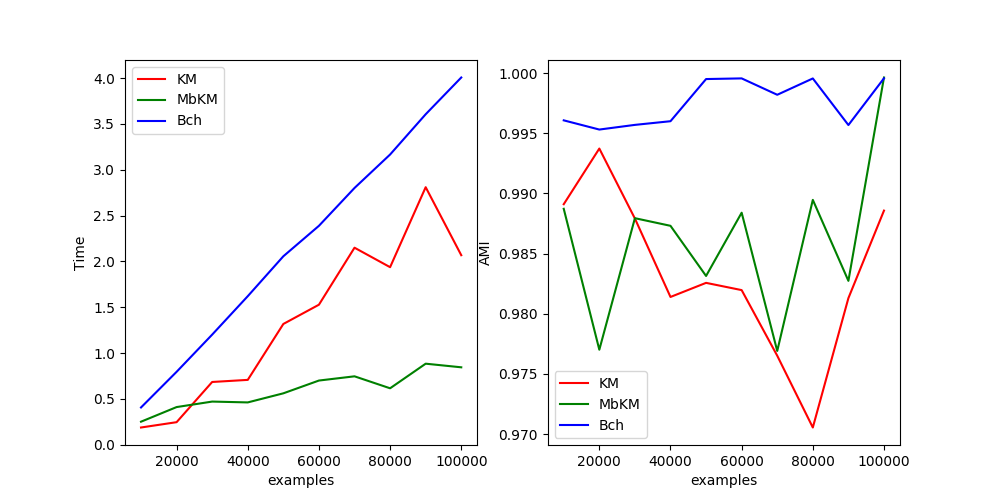

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plt.plot(range(step, limit, step), [x for x,_,_ in ltimes], color='r', label='KM')
plt.plot(range(step, limit, step), [x for _, x,_ in ltimes], color='g', label='MbKM')
plt.plot(range(step, limit, step), [x for _, _, x in ltimes], color='b', label="Bch")
plt.xlabel('examples')
plt.ylabel('Time')
plt.legend()
ax = fig.add_subplot(122)
plt.plot(range(step, limit, step), [x for x,_,_ in agree], color='r', label='KM')
plt.plot(range(step, limit, step), [x for _, x,_ in agree], color='g', label='MbKM')
plt.plot(range(step, limit, step), [x for _, _, x in agree], color='b', label="Bch")
plt.legend();
plt.ylabel('AMI')
plt.xlabel('examples');

You can play with the size of the datasets and specially with the number of clusters, you will see that with a small number of clusters if data fits in memory in general K-means is really fast. 